In [2]:
from tqdm import tqdm
import scipy
import rdata
from sklearn.model_selection import train_test_split
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from optax import adam, chain, clip

from numpyro import distributions as dist

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg

import math
import torch
import gpytorch




numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()

# Function 

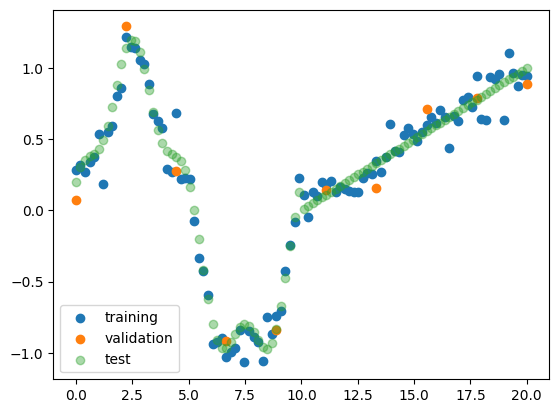

In [3]:
s_noise = 0.1

X_train = np.linspace(0,20,100).reshape(-1,1)
ind = (X_train<10)
y_train = (ind*1.0)*(np.sin(np.pi*X_train/5.0) + 0.2*np.cos(4.0*np.pi*X_train/5.0)) \
    + (np.invert(ind)*1.0)*(X_train/10.0 - 1.0) 
y_train = y_train.squeeze()
np.random.seed(70)
y_train = y_train + s_noise*np.random.normal(size=y_train.shape)

X_val = np.linspace(0,20,10).reshape(-1,1)
y_val = ((X_val<10)*1.0)*(np.sin(np.pi*X_val/5.0) + 0.2*np.cos(4.0*np.pi*X_val/5.0)) \
    + (np.invert((X_val<10))*1.0)*(X_val/10.0 - 1.0) 
y_val = y_val.squeeze()
np.random.seed(30)
y_val = y_val + s_noise*np.random.normal(size=y_val.shape)


X_test = np.linspace(0,20,100).reshape(-1,1)
# X_test = np.concatenate([X_test,X_train],axis=0)  # I want to include also de training points
# isort = np.argsort(X_test[:,0])
# X_test = X_test[isort,:]

ind = (X_test<10)
y_test = (ind*1.0)*(np.sin(np.pi*X_test/5.0) + 0.2*np.cos(4.0*np.pi*X_test/5.0)) \
    + (np.invert(ind)*1.0)*(X_test/10.0 - 1.0) 
y_test = y_test.squeeze()




plt.scatter(X_train,y_train,label = 'training');
plt.scatter(X_val,y_val,label = 'validation');
plt.scatter(X_test,y_test, label = "test",alpha = 0.4);
plt.legend();

# We fit two GPs to the training data

In [4]:
def train_and_predict_single_gp(X_train=X_train,y_train=y_train,X_test=X_test,X_val = X_val,init_noise=0.5):
    Xtrain_torch = torch.from_numpy(X_train)
    Ytrain_torch = torch.from_numpy(y_train).squeeze(-1)
    Xtest_torch = torch.from_numpy(X_test)
    Xval_torch = torch.from_numpy(X_val)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            lengthscale_prior = gpytorch.priors.GammaPrior(1, 1)
            outputscale_prior = gpytorch.priors.GammaPrior(1, 2)

            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
                ard_num_dims=Xtrain_torch.shape[1],
                lengthscale_prior = lengthscale_prior
                )
                ,outputscale_prior = outputscale_prior,
                )
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.GammaPrior(1, 1))
    model_gpy = ExactGPModel(Xtrain_torch, Ytrain_torch, likelihood)

    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(init_noise),
        'covar_module.base_kernel.lengthscale': torch.tensor(0.5)*torch.ones(X_train.shape[1],1),
        'covar_module.outputscale': torch.tensor(1.),
    }
    model_gpy.initialize(**hypers);

    training_iter = 100

    model_gpy.train()
    likelihood.train()   

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model_gpy.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs: - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gpy)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model_gpy(Xtrain_torch)  # this is for computing the prior GP model
        # Calc loss and backprop gradients
        loss = -mll(output, Ytrain_torch)
        loss.backward()
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model_gpy.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad():
        test_preds = likelihood(model_gpy(Xtest_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()
        train_preds = likelihood(model_gpy(Xtrain_torch)) # prediccion de las ytrain (no ftrain) ya que estamos usando likelihood()
        val_preds = likelihood(model_gpy(Xval_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()

        
    # compute the prior covariance matrix at the training inputs after fitting the hyperparameters
    model_gpy.train()   # we put the model on training model to have access to the prior predictive distribution
    with torch.no_grad():
        K_prior = likelihood(model_gpy(Xtrain_torch)).covariance_matrix.numpy()

    cholK_prior = scipy.linalg.cho_factor(K_prior)

    return test_preds, train_preds, val_preds, cholK_prior
   

In [209]:
# test_preds1, train_preds1, cholK_prior1 = train_and_predict_single_gp(X_train=X_train,y_train=y_train,X_test=X_test,init_noise=0.5)
# test_preds2, train_preds2, cholK_prior2 = train_and_predict_single_gp(X_train=X_train,y_train=y_train,X_test=X_test,init_noise=0.05)


# These are experts built with different training sets
X_train1 = X_train[:X_train.shape[0]//2,:]
X_train2 = X_train[X_train.shape[0]//2:,:]

y_train1 = y_train[:X_train.shape[0]//2]
y_train2 = y_train[X_train.shape[0]//2:]

test_preds1, train_preds1, val_preds1,cholK_prior1 = train_and_predict_single_gp(\
    X_train=X_train1,y_train=y_train1,X_test=X_test, X_val = X_val,init_noise=0.5)
test_preds2, train_preds2, val_preds2, cholK_prior2 = train_and_predict_single_gp(\
    X_train=X_train2,y_train=y_train2,X_test=X_test, X_val = X_val,init_noise=0.05)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


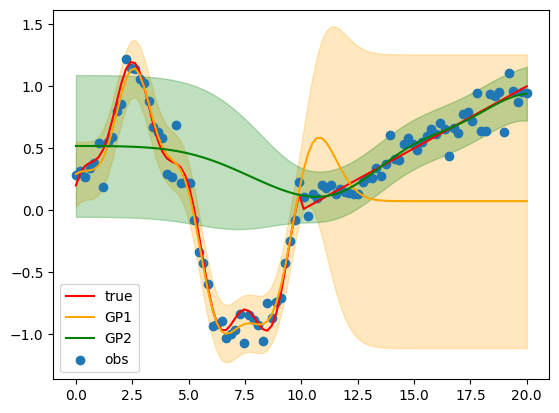

In [210]:

plt.plot(X_test,y_test,label = 'true', color = "red")
plt.plot(X_test,test_preds1.mean.numpy(), label = 'GP1', color = "orange")
upper, lower = test_preds1.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='orange', alpha = 0.25) 

plt.plot(X_test,test_preds2.mean.numpy(), label = 'GP2', color = "green")
upper, lower = test_preds2.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='green', alpha = 0.25) 
plt.scatter(X_train, y_train, label = 'obs')
plt.legend();

In [211]:
%%script True
# queria probar una cosa... las test_preds.mean y train_preds.mean parecian distintas pero es porque 
# el GP estaba prediciendo en cada X_train una delta, de forma que si dicho punto no estaba en X_test
# no observaba la misma forma...

plt.plot(X_train, train_preds1.mean.numpy())
plt.scatter(X_train, np.zeros(X_train.shape))
plt.plot(X_test, test_preds1.mean.numpy())
# plt.scatter(X_test, np.zeros(X_test.shape))

# Test the leave-one-out computation of posterior mean and variances for first GP

In [17]:
mu_loo = np.zeros(shape=(y_train.shape[0],2))
s2_loo = np.zeros(shape=(y_train.shape[0],2))

alpha1 = scipy.linalg.cho_solve(cholK_prior1,y_train)
alpha2 = scipy.linalg.cho_solve(cholK_prior2,y_train)
for i,y in enumerate(y_train):
    e = np.zeros(shape=y_train.shape)
    e[i] = 1
    aux1 = scipy.linalg.cho_solve(cholK_prior1,e)
    aux2 = scipy.linalg.cho_solve(cholK_prior2,e)
    
    s2_loo_inv1 = aux1[i]
    s2_loo_inv2 = aux2[i]
    
    mu_loo[i,0] = y - alpha1[i]/s2_loo_inv1
    s2_loo[i,0] = 1.0/s2_loo_inv1

    mu_loo[i,1] = y - alpha2[i]/s2_loo_inv2
    s2_loo[i,1] = 1.0/s2_loo_inv2


ValueError: incompatible dimensions ((15, 15) and (30,))

ValueError: x and y must have same first dimension, but have shapes (30, 1) and (15,)

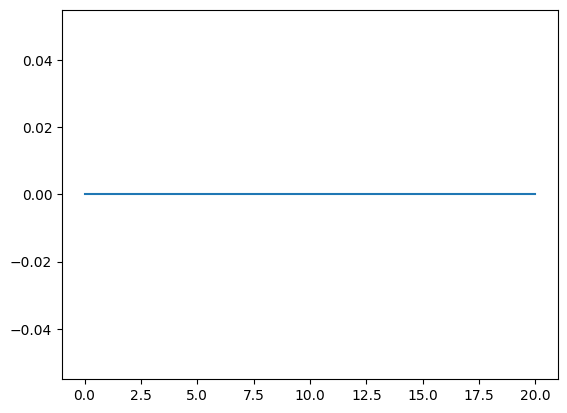

In [18]:
plt.plot(X_train, mu_loo[:,0], label = "mu_loo1")
plt.fill_between(X_train.squeeze(), mu_loo[:,0] + 2*np.sqrt(s2_loo[:,0]), mu_loo[:,0] - 2*np.sqrt(s2_loo[:,0]), alpha = 0.3)
plt.plot(X_train,train_preds1.mean.numpy(), label = 'GP1', color = "orange")
upper, lower = train_preds1.confidence_region()
plt.fill_between(X_train.squeeze(), upper.numpy(), lower.numpy(), color='orange', alpha = 0.3) 
plt.legend();

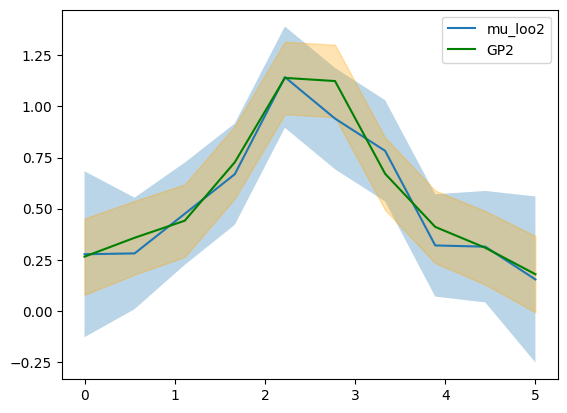

In [ ]:
plt.plot(X_train, mu_loo[:,1], label = "mu_loo2")
plt.fill_between(X_train.squeeze(), mu_loo[:,1] + 2*np.sqrt(s2_loo[:,1]), 
                 mu_loo[:,1] - 2*np.sqrt(s2_loo[:,1]), alpha = 0.3)
plt.plot(X_train,train_preds2.loc.numpy(), label = 'GP2', color = "green")
upper, lower = train_preds2.confidence_region()
plt.fill_between(X_train.squeeze(), upper.numpy(), lower.numpy(), color='orange', alpha = 0.3) 
plt.legend()

# PHS

In [6]:
# squared euclidean distance
def sqeuclidean_distance(x, y):
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func, x, y):
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

def SE_kernel(X, Y, var, length, noise, jitter=1.0e-6, include_noise=True):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, X / length, Y / length
    )

    assert deltaXsq.shape == (X.shape[0], Y.shape[0])

    # rbf function
    K = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        K += (noise + jitter) * jnp.eye(X.shape[0])
    return K

vmap_SE_kernel = jax.vmap(SE_kernel, in_axes=(None, None, 0, 0, 0))

def predict_with_mean(
    rng_key,
    X,
    Y,
    X_test,
    var,
    length,
    noise,
    kernel_func=SE_kernel,
    mean_func=lambda x: jnp.zeros(x.shape[0]),
):
    # compute kernels between train and test data, etc.
    k_pp = kernel_func(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel_func(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel_func(X, X, var, length, noise, include_noise=True)
    K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
    K = k_pp - jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, jnp.transpose(k_pX))
    )
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = mean_func(X_test) + jnp.matmul(
        k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y - mean_func(X))
    )
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, jnp.sqrt(jnp.diag(K))


vmapped_pred_with_mean = jax.vmap(
    predict_with_mean, in_axes=(None, None, 0, None, 0, 0, 0, None, None)
)

vmapped_pred_with_mean = jax.vmap(
    vmapped_pred_with_mean,
    in_axes=(None, None, 1, None, 1, 1, 1, None, None),
)

In [7]:
def mult_stack_gp_w_model(X, mu_preds, std_preds, y_val=None):
    N, M = mu_preds.shape

    assert mu_preds.shape == std_preds.shape

    tau_preds = 1 / std_preds**2

    ######################
    # GP for log weights #
    ######################
    with numpyro.plate("M", M):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_length = numpyro.sample("kernel_length", dist.InverseGamma(5.0, 5.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))

    k = numpyro.deterministic(
        "k", vmap_SE_kernel(X, X, kernel_var, kernel_length, kernel_noise)
    )

    with numpyro.plate("logw_plate", M, dim=-1):
        log_w = numpyro.sample(
            "w_un", dist.MultivariateNormal(loc=-jnp.log(M), covariance_matrix=k)
        )

    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(log_w))

    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->n", tau_preds, w)
    )  # N,

    assert tau_fused.shape == (N,)
    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->n", tau_preds, mu_preds, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused)),
        obs=y_val,
    )

    numpyro.deterministic(
        "lpd_point",
        jax.scipy.stats.norm.logpdf(
        jnp.squeeze(y_val), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused))    
    )

In [22]:
def mult_stack_gp_w_model_normalized_w(X, mu_preds, std_preds, y_val=None):
    N, M = mu_preds.shape

    assert mu_preds.shape == std_preds.shape

    tau_preds = 1 / std_preds**2

    ######################
    # GP for log weights #
    ######################
    with numpyro.plate("M", M):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_length = numpyro.sample("kernel_length", dist.InverseGamma(5.0, 5.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))

    k = numpyro.deterministic(
        "k", vmap_SE_kernel(X, X, kernel_var, kernel_length, kernel_noise)
    )

    with numpyro.plate("logw_plate", M, dim=-1):
        log_w = numpyro.sample(
            "w_un", dist.MultivariateNormal(loc=-jnp.log(M), covariance_matrix=k)
        )

    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################

    # w = numpyro.deterministic("w", jnp.exp(log_w))   
    w = numpyro.deterministic("w", jax.nn.softmax(log_w,axis=0))   # NORMALIZED WEIGHTS (THEY SUM UP TO 1)

    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->n", tau_preds, w)
    )  # N,

    assert tau_fused.shape == (N,)
    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->n", tau_preds, mu_preds, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))

    numpyro.sample(
        "y_val",
        dist.Normal(loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused)),
        obs=y_val,
    )

    numpyro.deterministic(
        "lpd_point",
        jax.scipy.stats.norm.logpdf(
        jnp.squeeze(y_val), loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused))    
    )

In [8]:
%%script true
mu_preds = mu_loo
std_preds = np.sqrt(s2_loo)

In [9]:
# data incest (and when both models share the training dataset)
# mu_preds = np.vstack([train_preds1.mean.numpy(), train_preds2.mean.numpy()]).T
# std_preds = np.sqrt(np.vstack([train_preds1.variance.numpy(), train_preds2.variance.numpy()]).T)

# X_fusion = X_train
# y_fusion = y_train

# # here I'm considering GPs built with different training datasets so I use the test data set for training the weights
# mu_preds = np.vstack([test_preds1.mean.numpy(), test_preds2.mean.numpy()]).T
# std_preds = np.sqrt(np.vstack([test_preds1.variance.numpy(), test_preds2.variance.numpy()]).T)

# X_fusion = X_test
# y_fusion = y_test

# here I'm considering GPs built with different training datasets so I use the test data set for training the weights
mu_preds = np.concatenate([val_preds1.mean.numpy().reshape(-1,1), val_preds2.mean.numpy().reshape(-1,1)],axis=1)
std_preds = np.sqrt(np.concatenate([val_preds1.variance.numpy().reshape(-1,1), val_preds2.variance.numpy().reshape(-1,1)],axis=1))

X_fusion = X_val
y_fusion = y_val

NameError: name 'val_preds1' is not defined

In [372]:
mcmc = MCMC(
    NUTS(mult_stack_gp_w_model, init_strategy=numpyro.infer.initialization.init_to_median),
    num_warmup=100,
    num_samples=100,
    num_chains=4,
)


mcmc.run(random.PRNGKey(0), 
         X_fusion,   
         mu_preds, 
         std_preds, 
         y_val=y_fusion, 
         )
mcmc.print_summary()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.29      0.78      1.09      0.44      2.24    155.61      1.01
kernel_length[1]      1.27      0.70      1.09      0.38      2.21    303.74      1.01
 kernel_noise[0]      0.65      0.53      0.55      0.01      1.34    168.79      1.02
 kernel_noise[1]      0.93      0.65      0.82      0.05      1.92    302.51      1.01
   kernel_var[0]      0.65      0.55      0.52      0.00      1.44    206.77      1.02
   kernel_var[1]      0.85      0.61      0.73      0.00      1.67    273.91      1.01
       w_un[0,0]     -1.02      0.82     -0.95     -2.22      0.25    510.77      1.00
       w_un[0,1]     -1.12      0.81     -1.04     -2.27      0.28    578.37      1.00
       w_un[0,2]     -0.56      1.00     -0.51     -1.96      1.30    463.66      1.00
       w_un[0,3]      0.06      1.04      0.04     -1.52      1.72    243.45      1.00
       w_un[0,4]     -0.21      0.83     -

In [373]:
mu_fused = mcmc.get_samples()["mean_fused"]
std_fused = mcmc.get_samples()["std_fused"]

lpd_point = jax.scipy.stats.norm.logpdf(
                y_fusion, loc=jnp.squeeze(mu_fused), scale=jnp.squeeze(std_fused),
                )

lpd_phs_val = jax.nn.logsumexp(lpd_point,axis=0) - np.log(lpd_point.shape[0])


print(lpd_phs_val.mean())

0.5960494496530994


In [374]:
%%script true
# computing the average standardized negative log-likelihood of the points wrt their univariate predictive densities
train_lpd1 = gpytorch.metrics.mean_standardized_log_loss(train_preds1, torch.from_numpy(y_train).squeeze(-1))
train_lpd2 = gpytorch.metrics.mean_standardized_log_loss(train_preds2, torch.from_numpy(y_train).squeeze(-1))

print(f'Train lpd GP1: {-train_lpd1:.4f}, \nTrain lpd GP2: {-train_lpd2:.4f}')
print(f"train lpd phs: {lpd_phs_train.mean(0):.4f}")

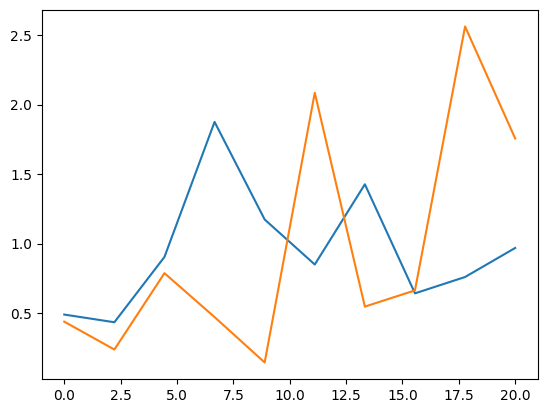

In [375]:
ola = mcmc.get_samples()["w"].mean(0)
plt.plot(X_fusion, ola[0,:], label ="weights GP1")
plt.plot(X_fusion, ola[1,:], label ="weights GP2")

In [376]:
%%script true
# this is only when we used X_train for training GP1,GP2 and PHS
plt.plot(X_train,mu_fused.mean(0),label = 'PHS train')
plt.plot(X_train,train_preds1.loc.numpy(),'--',label = 'GP1 train')
plt.plot(X_train,train_preds2.loc.numpy(),'--',label = 'GP2 train')
plt.legend();

In [377]:
# here we want to get predictions of PHS on the test data

samples = mcmc.get_samples()
res = vmapped_pred_with_mean(
    random.PRNGKey(0),
    X_fusion,
    samples["w_un"],
    X_test,  # TEST DATA
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
    SE_kernel,
    lambda x: -jnp.log(2) * jnp.ones(x.shape[0]),
)


# log_w_samples = jnp.asarray(res[0] + np.random.randn(*res[0].shape) * res[1]) # sampling from the posterior predictive of the log-weights
log_w_samples = jnp.asarray(res[0])  # by doing this we only use the mean of the posterior predictive of the log-weights
pred_samples = {"w_un": jnp.transpose(log_w_samples, (1, 0, 2))}
# but we could sample more than log_w for each MCMC sample...



predictive = Predictive(mult_stack_gp_w_model, pred_samples)
pred_samples = predictive(
    random.PRNGKey(0),
    X=X_test,  # TEST DATA
    mu_preds=np.vstack([test_preds1.loc.numpy(),test_preds2.loc.numpy()]).T,  # TEST DATA
    std_preds=np.sqrt(np.vstack([test_preds1.variance.numpy(),test_preds2.variance.numpy()]).T), # TEST DATA
    y_val=y_test,
)

lpd_point = jax.scipy.stats.norm.logpdf(
                y_test, loc=jnp.squeeze(pred_samples["mean_fused"]), 
                scale=jnp.squeeze(pred_samples["std_fused"]),
                )

lpd_phs_test = jax.nn.logsumexp(lpd_point,axis=0) - np.log(lpd_point.shape[0])

# ahora jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0]) da el mismo resultado

In [378]:
print(lpd_phs_test.mean())
print((jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0])).mean(0))

0.8921103800467286
0.8921103800467286


In [379]:
# computing the average standardized negative log-likelihood of the points wrt their univariate predictive densities
test_lpd1 = gpytorch.metrics.mean_standardized_log_loss(test_preds1, torch.from_numpy(y_test).squeeze(-1))
test_lpd2 = gpytorch.metrics.mean_standardized_log_loss(test_preds2, torch.from_numpy(y_test).squeeze(-1))

print(f'Test lpd GP1: {-test_lpd1:.4f}, \nTrain lpd GP2: {-test_lpd2:.4f}')
print(f"test lpd phs: {lpd_phs_test.mean(0):.4f}")

Test lpd GP1: 0.1267, 
Train lpd GP2: -2.1288
test lpd phs: 0.8921


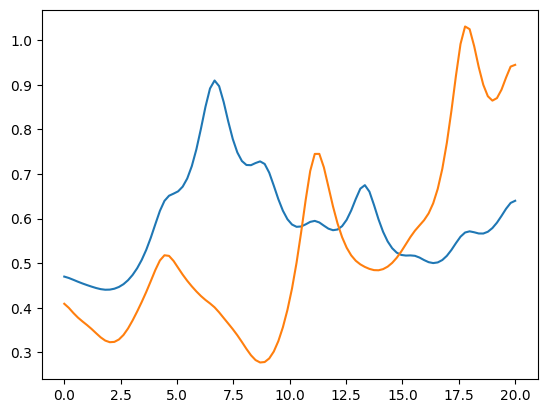

In [380]:
ola = pred_samples["w"].mean(0)
plt.plot(X_test, ola[0,:], label ="weights GP1")
plt.plot(X_test, ola[1,:], label ="weights GP2")

In [381]:
def sample_mixture_gaussian(n_samples, means, std_devs):
    # Number of Gaussian components
    n_components = len(means)
    
    if len(std_devs) != n_components:
        raise ValueError("The number of means and standard deviations must be the same")
    
    # Equal weights for the uniform mixture
    weights = np.full(n_components, 1.0 / n_components)
    
    # Sample from a uniform distribution to decide which Gaussian to sample from
    mixture_component = np.random.choice(n_components, size=n_samples, p=weights)
    
    # Allocate array for samples
    samples = np.zeros(n_samples)
    
    # Sample from each Gaussian based on the mixture component
    for i in range(n_components):
        component_samples = np.random.normal(loc=means[i], scale=std_devs[i], size=np.sum(mixture_component == i))
        samples[mixture_component == i] = component_samples
    
    return samples


n_samples = 1000
samples_phs = np.zeros((X_test.shape[0],n_samples))
for i in range(X_test.shape[0]):

    means =  pred_samples["mean_fused"][:,i] # Means of the Gaussians
    std_devs = pred_samples["std_fused"][:,i] # Standard deviations of the Gaussians

    samples_phs[i,:] = sample_mixture_gaussian(n_samples, means, std_devs)

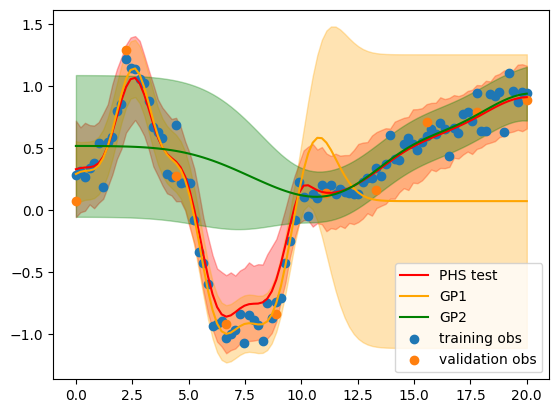

In [384]:
plt.plot(X_test, pred_samples["mean_fused"].mean(0), label = "PHS test",color="red")
# plt.fill_between(X_test.squeeze(), 
                #  np.percentile(pred_samples["y_val"],axis=0,q=97.5),
                #  np.percentile(pred_samples["y_val"],axis=0,q=2.5), color = "red", alpha = 0.3)
# ---- otra forma -----
plt.fill_between(X_test.squeeze(), 
                 np.percentile(samples_phs,axis=1,q=97.5),
                 np.percentile(samples_phs,axis=1,q=2.5), color = "red", alpha = 0.3)

plt.plot(X_test,test_preds1.mean.numpy(), label = 'GP1', color = "orange")
upper, lower = test_preds1.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='orange', alpha = 0.3) 

plt.plot(X_test,test_preds2.mean.numpy(), label = 'GP2', color = "green")
upper, lower = test_preds2.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='green', alpha = 0.3) 
plt.scatter(X_train, y_train, label = 'training obs')
plt.scatter(X_val, y_val, label = 'validation obs')
plt.legend();

# BHS

In [36]:
def bhs(X, mu_preds, std_preds, y_val=None):
    N, M = mu_preds.shape

    assert mu_preds.shape == std_preds.shape

    ######################
    # GP for log weights #
    ######################
    with numpyro.plate("M", M):
        kernel_var = numpyro.sample("kernel_var", dist.HalfNormal(1.0))
        kernel_length = numpyro.sample(
            "kernel_length", dist.InverseGamma(5.0, 5.0))
        kernel_noise = numpyro.sample("kernel_noise", dist.HalfNormal(1.0))

    k = numpyro.deterministic(
        "k", vmap_SE_kernel(X, X, kernel_var, kernel_length, kernel_noise)
    )

    with numpyro.plate("logw_plate", M, dim=-1):
        w_un = numpyro.sample(
            "w_un", dist.MultivariateNormal(
                loc=-jnp.log(M), covariance_matrix=k)
        )

    log_w = jax.nn.log_softmax(w_un.T, axis=1)

    #################
    # Fuse with BHS #
    #################
    y_val_rep = jnp.tile(jnp.reshape(y_val, (-1, 1)), M)
    lpd_point = jax.scipy.stats.norm.logpdf(
        y_val_rep, loc=mu_preds, scale=std_preds)
    logp = jax.nn.logsumexp(lpd_point + log_w, axis=1)
    numpyro.deterministic("lpd_point", logp)
    numpyro.deterministic("w", jnp.exp(log_w))
    numpyro.factor("logp", jnp.sum(logp))


In [268]:
mcmc = MCMC(
    NUTS(bhs, 
         init_strategy=numpyro.infer.initialization.init_to_median),
    num_warmup=1_00,
    num_samples=1_00,
    num_chains=4,
)

mcmc.run(random.PRNGKey(0), 
         X_fusion, 
         mu_preds,
         std_preds, 
         y_val=y_fusion)
mcmc.print_summary()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.28      0.73      1.10      0.46      2.12    237.05      1.02
kernel_length[1]      1.34      0.91      1.09      0.40      2.28    100.44      1.03
 kernel_noise[0]      0.74      0.55      0.66      0.00      1.52     93.01      1.02
 kernel_noise[1]      0.81      0.59      0.68      0.01      1.70    149.61      1.02
   kernel_var[0]      0.78      0.56      0.70      0.01      1.61    116.51      1.03
   kernel_var[1]      0.75      0.60      0.62      0.01      1.60    144.00      1.02
       w_un[0,0]     -0.46      1.20     -0.50     -2.26      1.67    590.40      0.99
       w_un[0,1]     -0.30      1.08     -0.35     -2.02      1.39    692.18      1.00
       w_un[0,2]     -0.47      1.13     -0.45     -2.28      1.51    424.56      1.01
       w_un[0,3]     -0.20      1.11     -0.23     -1.95      1.64    282.94      1.01
       w_un[0,4]     -0.24      1.14     -

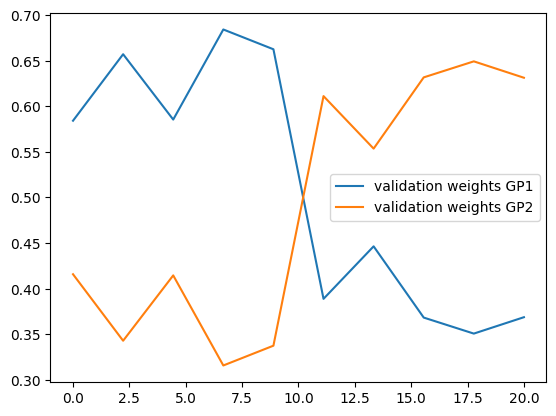

In [269]:
plt.plot(X_val, mcmc.get_samples()["w"].mean(0)[:,0], label = "validation weights GP1")
plt.plot(X_val, mcmc.get_samples()["w"].mean(0)[:,1], label = "validation weights GP2")
plt.legend()

In [270]:
lpd_bhs_train = jax.nn.logsumexp(mcmc.get_samples()["lpd_point"],axis=0) - \
    np.log(mcmc.get_samples()["lpd_point"].shape[0])


samples = mcmc.get_samples()
res = vmapped_pred_with_mean(
    random.PRNGKey(0),
    X_fusion,
    samples["w_un"],
    X_test, # TEST DATA
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
    SE_kernel,
    lambda x:  jnp.zeros(x.shape[0]),
)


# w_un_samples = jnp.asarray(res[0] + np.random.randn(*res[0].shape) * res[1])
w_un_samples = jnp.asarray(res[0])
pred_samples = {"w_un": jnp.transpose(w_un_samples, (1, 0, 2))}

predictive = Predictive(bhs, pred_samples)
pred_samples = predictive(
    random.PRNGKey(0),
    X=X_test, # TEST DATA
    mu_preds=np.vstack([test_preds1.loc.numpy(),test_preds2.loc.numpy()]).T,  # TEST DATA
    std_preds=np.sqrt(np.vstack([test_preds1.variance.numpy(),test_preds2.variance.numpy()]).T), # TEST DATA
    y_val = y_test, # TEST DATA
)

lpd_bhs_test = jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0])


In [271]:
print(lpd_bhs_test.mean())

0.7730912954627266


In [272]:
w_bhs = pred_samples["w"].mean(0)

mu_preds_test = np.vstack([test_preds1.loc.numpy(),test_preds2.loc.numpy()]).T
std_preds_test=np.sqrt(np.vstack([test_preds1.variance.numpy(),test_preds2.variance.numpy()]).T)

ymu_bhs = np.sum(np.multiply(w_bhs,mu_preds_test),axis=1)

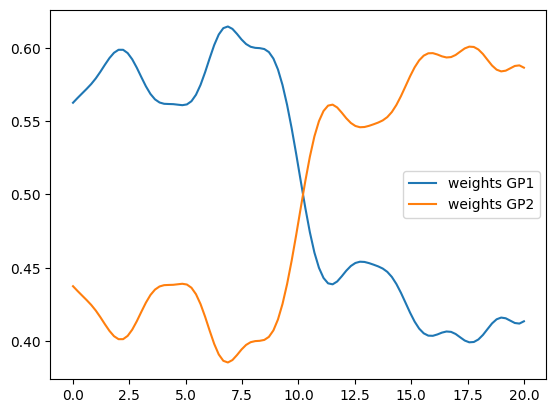

In [273]:
plt.plot(X_test, w_bhs[:,0], label = "weights GP1")
plt.plot(X_test, w_bhs[:,1], label = "weights GP2")
plt.legend();

In [274]:
def sample_mixture_gaussian(n_samples, means, std_devs, weights):
    # Check that weights sum to 1
    if not np.isclose(sum(weights), 1.0):
        raise ValueError("Weights must sum to 1")
    
    # Check that means and std_devs have length 2
    if len(means) != 2 or len(std_devs) != 2:
        raise ValueError("Means and standard deviations must each have length 2")
    
    # Sample from a uniform distribution to decide which Gaussian to sample from
    mixture_component = np.random.choice([0, 1], size=n_samples, p=weights)
    
    # Allocate array for samples
    samples = np.zeros(n_samples)
    
    # Sample from the first Gaussian
    samples[mixture_component == 0] = np.random.normal(loc=means[0], scale=std_devs[0], size=np.sum(mixture_component == 0))
    
    # Sample from the second Gaussian
    samples[mixture_component == 1] = np.random.normal(loc=means[1], scale=std_devs[1], size=np.sum(mixture_component == 1))
    
    return samples

# Example usage
n_samples = 1000
samples_bhs = np.zeros((X_test.shape[0],n_samples))
for i in range(X_test.shape[0]):
    means = mu_preds_test[i,:]  # Means of the two Gaussians
    std_devs = std_preds_test[i,:]  # Standard deviations of the two Gaussians
    weights = w_bhs[i,:]  # Weights for the two Gaussians (must sum to 1)

    samples_bhs[i,:] = sample_mixture_gaussian(n_samples, means, std_devs, weights)

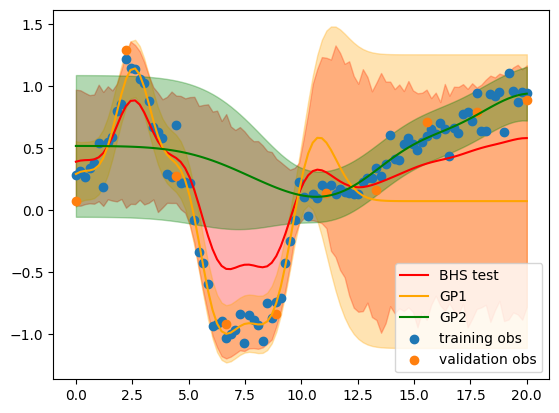

In [275]:
plt.plot(X_test, ymu_bhs, label = "BHS test",color="red")
plt.fill_between(X_test.squeeze(), 
                 np.percentile(samples_bhs,axis=1,q=97.5),
                 np.percentile(samples_bhs,axis=1,q=2.5), color = "red", alpha = 0.3)
plt.plot(X_test,test_preds1.mean.numpy(), label = 'GP1', color = "orange")
upper, lower = test_preds1.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='orange', alpha = 0.3) 

plt.plot(X_test,test_preds2.mean.numpy(), label = 'GP2', color = "green")
upper, lower = test_preds2.confidence_region()
plt.fill_between(X_test.squeeze(), upper.numpy(), lower.numpy(), color='green', alpha = 0.3) 
plt.scatter(X_train, y_train, label = 'training obs')
plt.scatter(X_val, y_val, label = 'validation obs')
plt.legend();

# More general code for stacking

In [439]:
mu_preds_val = np.vstack([val_preds1.loc.numpy(),val_preds2.loc.numpy()]).T
std_preds_val=np.sqrt(np.vstack([val_preds1.variance.numpy(),val_preds2.variance.numpy()]).T)

mu_preds_test = np.vstack([test_preds1.loc.numpy(),test_preds2.loc.numpy()]).T
std_preds_test=np.sqrt(np.vstack([test_preds1.variance.numpy(),test_preds2.variance.numpy()]).T)

In [15]:
def train_stacking(model=None):
    mcmc = MCMC(
    NUTS(model, 
         init_strategy=numpyro.infer.initialization.init_to_median,
         ),
    num_warmup=100,
    num_samples=100,
    num_chains=4,
)

    mcmc.run(random.PRNGKey(0), 
            X_val,   
            mu_preds_val, 
            std_preds_val, 
            y_val=y_val, 
            )
    mcmc.print_summary()
    samples = mcmc.get_samples()

    return samples


def predict_stacking(model,samples,prior_mean = lambda x:  jnp.zeros(x.shape[0])):

    res = vmapped_pred_with_mean(
        random.PRNGKey(0),
        X_val,
        samples["w_un"],
        X_test, # TEST DATA
        samples["kernel_var"],
        samples["kernel_length"],
        samples["kernel_noise"],
        SE_kernel,
        prior_mean,
    )


    # w_un_samples = jnp.asarray(res[0] + np.random.randn(*res[0].shape) * res[1])
    w_un_samples = jnp.asarray(res[0])
    pred_samples = {"w_un": jnp.transpose(w_un_samples, (1, 0, 2))}

    predictive = Predictive(model, pred_samples)
    pred_samples = predictive(
        random.PRNGKey(0),
        X=X_test, # TEST DATA
        mu_preds=mu_preds_test,  # TEST DATA
        std_preds=std_preds_test, # TEST DATA
        y_val = y_test, # TEST DATA
    )

    lpd_test = jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0])

    return pred_samples, lpd_test



def get_ysamples(mus,stds,w):
    def sample_mixture_gaussian(n_samples, means, std_devs, weights):    
        n_components = len(means)
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1") # Check that weights sum to 1
        
        if len(std_devs) != n_components:
            raise ValueError("The number of means and standard deviations must be the same")
        
        # Sample from a uniform distribution to decide which Gaussian to sample from
        mixture_component = np.random.choice(n_components, size=n_samples, p=weights)
        
        # Allocate array for samples
        samples = np.zeros(n_samples)
        
        # Sample from each Gaussian based on the mixture component
        for i in range(n_components):
            component_samples = np.random.normal(loc=means[i], scale=std_devs[i], size=np.sum(mixture_component == i))
            samples[mixture_component == i] = component_samples
        
        return samples
        
    n_samples = 1000
    ysamples = np.zeros((X_test.shape[0],n_samples))
    for i in range(X_test.shape[0]):
        means = mus[i,:]  # Means of the two Gaussians
        std_devs = stds[i,:]  # Standard deviations of the two Gaussians
        weights = w[i,:]  # Weights for the two Gaussians (must sum to 1)

        ysamples[i,:] = sample_mixture_gaussian(n_samples, means, std_devs, weights)

    return ysamples


def plot_stacking(w, ysamples):
    import matplotlib
    # Define the colormap
    cmap = matplotlib.colormaps['tab10']

    # w = pred_samples["w"].mean(0).T
    plt.figure()
    for i in range(w.shape[0]):
        plt.plot(X_test, w[i,:], label = f"weights GP{i}",color=cmap(i))
        plt.legend()
        plt.title("expert weights BHS")

    plt.figure()
    plt.plot(X_test, ysamples.mean(1), label = "BHS test",color="red")
    plt.fill_between(X_test.squeeze(), 
                 np.percentile(ysamples,axis=1,q=97.5),
                 np.percentile(ysamples,axis=1,q=2.5), color = "red", alpha = 0.4)  
    for i in range(w.shape[0]):
        plt.plot(X_test,mu_preds_test[:,i], label = f'GP{i}',color=cmap(i))
        plt.fill_between(X_test.squeeze(), 
                         mu_preds_test[:,i] + 2*std_preds_test[:,i], # 95% CI
                         mu_preds_test[:,i] - 2*std_preds_test[:,i],
                         color=cmap(i), alpha = 0.15) 
    plt.scatter(X_train, y_train, label = 'training obs')
    plt.scatter(X_val, y_val, label = 'validation obs')
    # plt.title("BHS")
    plt.legend()     

In [441]:
samples_bhs = train_stacking(model=bhs)
preds_bhs, lpd_bhs_test = predict_stacking(bhs,samples=samples_bhs)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.28      0.73      1.10      0.46      2.12    237.05      1.02
kernel_length[1]      1.34      0.91      1.09      0.40      2.28    100.44      1.03
 kernel_noise[0]      0.74      0.55      0.66      0.00      1.52     93.01      1.02
 kernel_noise[1]      0.81      0.59      0.68      0.01      1.70    149.61      1.02
   kernel_var[0]      0.78      0.56      0.70      0.01      1.61    116.51      1.03
   kernel_var[1]      0.75      0.60      0.62      0.01      1.60    144.00      1.02
       w_un[0,0]     -0.46      1.20     -0.50     -2.26      1.67    590.40      0.99
       w_un[0,1]     -0.30      1.08     -0.35     -2.02      1.39    692.18      1.00
       w_un[0,2]     -0.47      1.13     -0.45     -2.28      1.51    424.56      1.01
       w_un[0,3]     -0.20      1.11     -0.23     -1.95      1.64    282.94      1.01
       w_un[0,4]     -0.24      1.14     -

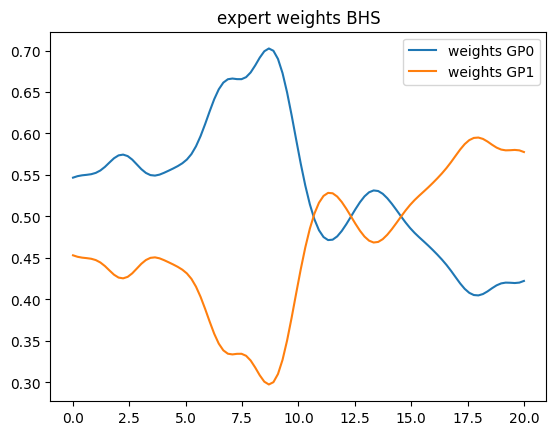

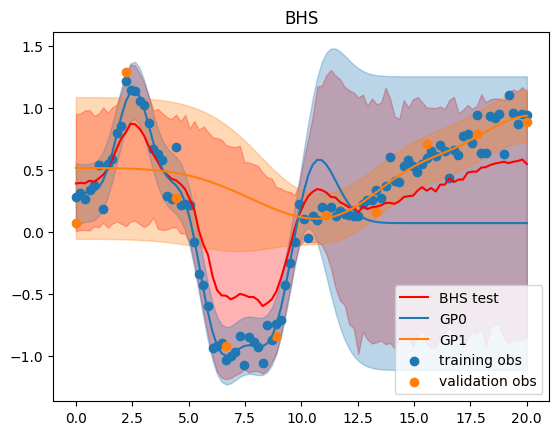

In [442]:
ysamples = get_ysamples(mus=mu_preds_test,stds=std_preds_test,w=preds_bhs["w"].mean(0))

plot_stacking(preds_bhs["w"].mean(0).T,ysamples)

Let's try the general code with phs

In [443]:
samples_phs = train_stacking(model=mult_stack_gp_w_model)
preds_phs, lpd_phs_test = predict_stacking(mult_stack_gp_w_model,
                                           samples=samples_phs,
                                           prior_mean=lambda x: 
                                           -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0]))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.29      0.78      1.09      0.44      2.24    155.61      1.01
kernel_length[1]      1.27      0.70      1.09      0.38      2.21    303.74      1.01
 kernel_noise[0]      0.65      0.53      0.55      0.01      1.34    168.79      1.02
 kernel_noise[1]      0.93      0.65      0.82      0.05      1.92    302.51      1.01
   kernel_var[0]      0.65      0.55      0.52      0.00      1.44    206.77      1.02
   kernel_var[1]      0.85      0.61      0.73      0.00      1.67    273.91      1.01
       w_un[0,0]     -1.02      0.82     -0.95     -2.22      0.25    510.77      1.00
       w_un[0,1]     -1.12      0.81     -1.04     -2.27      0.28    578.37      1.00
       w_un[0,2]     -0.56      1.00     -0.51     -1.96      1.30    463.66      1.00
       w_un[0,3]      0.06      1.04      0.04     -1.52      1.72    243.45      1.00
       w_un[0,4]     -0.21      0.83     -

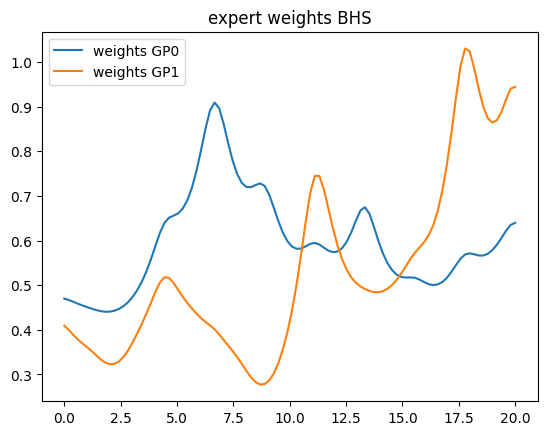

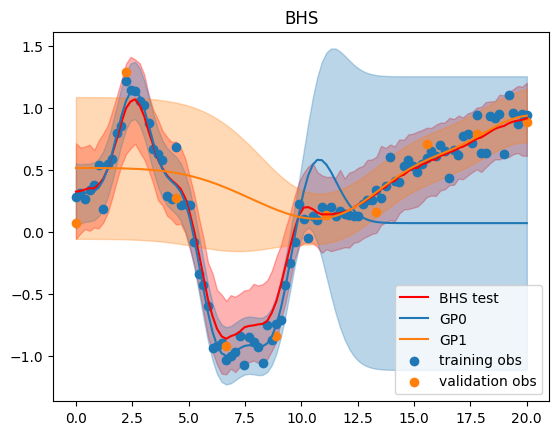

In [444]:
n_components = samples_phs["w"].shape[0]
ysamples = get_ysamples(mus=preds_phs["mean_fused"].T,
                        stds=preds_phs["std_fused"].T,
                        w=np.full((X_test.shape[0],n_components), 1.0 / n_components))
w = pred_samples["w"].mean(0)
plot_stacking(w,ysamples)

In [446]:
print(lpd_phs_test.mean(),lpd_bhs_test.mean())

0.8921103800467286 0.7619615822907132


# CASE: experts with subsets of data

In [5]:
def split_dataset(X, Y, n_splits, split_size, with_replacement=True):
    """
    Splits the dataset into a specified number of datasets with or without replacement.
    
    Parameters:
    X (numpy array): The feature dataset to be split.
    Y (numpy array): The corresponding labels dataset to be split.
    n_splits (int): Number of datasets to split into.
    with_replacement (bool): Whether to sample with replacement or not.
    
    Returns:
    list of tuples: Each tuple contains two numpy arrays, the split X and Y datasets.
    """
    np.random.seed(0)
    n_samples = X.shape[0]
    # split_size = n_samples // n_splits

    if with_replacement:
        splits = [(X[indices], Y[indices]) for indices in [np.random.choice(n_samples, split_size, replace=True) for _ in range(n_splits)]]
    else:
        if split_size * n_splits > n_samples:
            raise ValueError("Cannot split without replacement as there are not enough samples.")
        indices = np.random.permutation(n_samples)
        splits = [(X[indices[i * split_size:(i + 1) * split_size]], Y[indices[i * split_size:(i + 1) * split_size]]) for i in range(n_splits)]
    
    
    return splits


We are going to create splits of the training dataset and fit a GP to each of them; then plot the results

In [159]:
s_noise = 0.1
X_train = np.linspace(0,20,100).reshape(-1,1)
ind = (X_train<10)
y_train = (ind*1.0)*(np.sin(np.pi*X_train/5.0) + 0.2*np.cos(4.0*np.pi*X_train/5.0)) \
    + (np.invert(ind)*1.0)*(X_train/10.0 - 1.0) 
y_train = y_train.squeeze()
np.random.seed(70)
y_train = y_train + s_noise*np.random.normal(size=y_train.shape)


X_val = np.linspace(0,20,10).reshape(-1,1)
y_val = ((X_val<10)*1.0)*(np.sin(np.pi*X_val/5.0) + 0.2*np.cos(4.0*np.pi*X_val/5.0)) \
    + (np.invert((X_val<10))*1.0)*(X_val/10.0 - 1.0) 
y_val = y_val.squeeze()
np.random.seed(30)
y_val = y_val + s_noise*np.random.normal(size=y_val.shape)

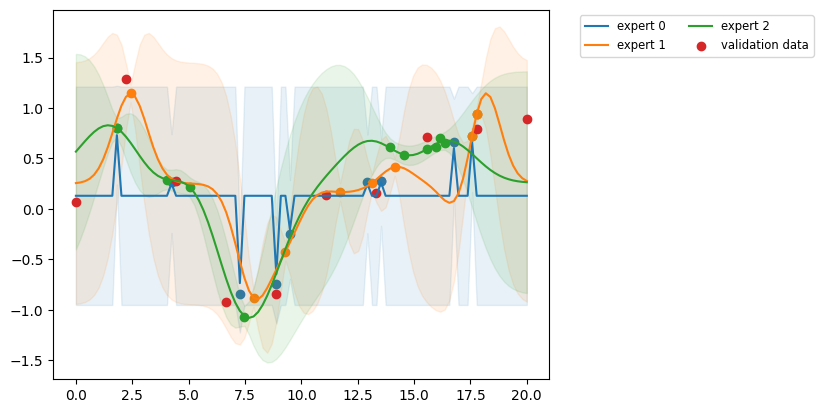

In [185]:
import matplotlib

splits = split_dataset(X_train, y_train, n_splits=3, split_size=10, with_replacement=True)


mu_preds_val = np.zeros((X_val.shape[0],len(splits)))
std_preds_val = np.zeros((X_val.shape[0],len(splits)))

mu_preds_test = np.zeros((X_test.shape[0],len(splits)))
std_preds_test = np.zeros((X_test.shape[0],len(splits)))


# cmap = matplotlib.colormaps['viridis']
cmap = matplotlib.colormaps['tab10']
for i, (X_split, y_split) in enumerate(splits):
   test_preds, _, val_preds, _ =  train_and_predict_single_gp(X_train=X_split,
                                y_train=y_split,
                                X_test=X_test,
                                X_val = X_val,
                                init_noise=1)
   
   mu_preds_val[:,i] = val_preds.mean.numpy()
   std_preds_val[:,i] = np.sqrt(val_preds.variance.numpy())

   mu_preds_test[:,i] = test_preds.mean.numpy()
   std_preds_test[:,i] = np.sqrt(test_preds.variance.numpy())
  

   plt.scatter(X_split,y_split, 
              #  color = cmap(i / len(splits)),
              color = cmap(i),
               )
   plt.plot(X_test,mu_preds_test[:,i], 
            # color = cmap(i / len(splits)), 
            color = cmap(i),
            label = f'expert {i}')
   plt.fill_between(X_test.squeeze(),
                    mu_preds_test[:,i] + 2*std_preds_test[:,i], 
                    mu_preds_test[:,i] - 2*std_preds_test[:,i],
                  #   color = cmap(i / len(splits)),
                    color = cmap(i),
                    alpha=0.1,
                    )
plt.scatter(X_val,y_val,label="validation data",color = cmap(i+1))
# plt.legend();
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')    


In [186]:
def train_stacking(model=None):
    mcmc = MCMC(
    NUTS(model, 
         init_strategy=numpyro.infer.initialization.init_to_median,
         ),
    num_warmup=100,
    num_samples=100,
    num_chains=4,
)

    mcmc.run(random.PRNGKey(0), 
            X_val,   
            mu_preds_val, 
            std_preds_val, 
            y_val=y_val, 
            )
    mcmc.print_summary()
    samples = mcmc.get_samples()

    return samples


def predict_stacking(model,samples,prior_mean = lambda x:  jnp.zeros(x.shape[0])):

    res = vmapped_pred_with_mean(
        random.PRNGKey(0),
        X_val,
        samples["w_un"],
        X_test, # TEST DATA
        samples["kernel_var"],
        samples["kernel_length"],
        samples["kernel_noise"],
        SE_kernel,
        prior_mean,
    )


    # w_un_samples = jnp.asarray(res[0] + np.random.randn(*res[0].shape) * res[1])
    w_un_samples = jnp.asarray(res[0])
    pred_samples = {"w_un": jnp.transpose(w_un_samples, (1, 0, 2))}

    predictive = Predictive(model, pred_samples)
    pred_samples = predictive(
        random.PRNGKey(0),
        X=X_test, # TEST DATA
        mu_preds=mu_preds_test,  # TEST DATA
        std_preds=std_preds_test, # TEST DATA
        y_val = y_test, # TEST DATA
    )

    lpd_test = jax.nn.logsumexp(pred_samples["lpd_point"],axis=0) - np.log(pred_samples["lpd_point"].shape[0])

    return pred_samples, lpd_test



def get_ysamples(mus,stds,w):
    def sample_mixture_gaussian(n_samples, means, std_devs, weights):    
        n_components = len(means)
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1") # Check that weights sum to 1
        
        if len(std_devs) != n_components:
            raise ValueError("The number of means and standard deviations must be the same")
        
        # Sample from a uniform distribution to decide which Gaussian to sample from
        mixture_component = np.random.choice(n_components, size=n_samples, p=weights)
        
        # Allocate array for samples
        samples = np.zeros(n_samples)
        
        # Sample from each Gaussian based on the mixture component
        for i in range(n_components):
            component_samples = np.random.normal(loc=means[i], scale=std_devs[i], size=np.sum(mixture_component == i))
            samples[mixture_component == i] = component_samples
        
        return samples
        
    n_samples = 1000
    ysamples = np.zeros((X_test.shape[0],n_samples))
    for i in range(X_test.shape[0]):
        means = mus[i,:]  # Means of the two Gaussians
        std_devs = stds[i,:]  # Standard deviations of the two Gaussians
        weights = w[i,:]  # Weights for the two Gaussians (must sum to 1)

        ysamples[i,:] = sample_mixture_gaussian(n_samples, means, std_devs, weights)

    return ysamples


def plot_stacking(w, ysamples):
    import matplotlib
    # Define the colormap
    cmap = matplotlib.colormaps['tab10']

    # w = pred_samples["w"].mean(0).T
    plt.figure()
    for i in range(w.shape[0]):    # plotting the weights of the experts
        plt.plot(X_test, w[i,:], label = f"weights GP{i}",color=cmap(i))
        # plt.legend()
        plt.title("expert weights")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')    

    plt.figure()
    plt.plot(X_test, ysamples.mean(1), label = "stacking",
             color="magenta",
             linewidth=3)
    plt.fill_between(X_test.squeeze(), 
                 np.percentile(ysamples,axis=1,q=97.5),
                 np.percentile(ysamples,axis=1,q=2.5), 
                 color = "magenta",
                 alpha = 0.4)  
    for i in range(w.shape[0]):
        plt.plot(X_test,mu_preds_test[:,i], label = f'GP{i}',color=cmap(i))
        plt.fill_between(X_test.squeeze(), 
                         mu_preds_test[:,i] + 2*std_preds_test[:,i], # 95% CI
                         mu_preds_test[:,i] - 2*std_preds_test[:,i],
                         color=cmap(i), alpha = 0.15) 
    # plt.scatter(X_train, y_train, label = 'training obs')
    plt.scatter(X_val, y_val, label = 'validation obs',color=cmap(i+1))
    # plt.title("BHS")
    # plt.legend()     
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')

## PHS

In [187]:
samples_phs = train_stacking(
    model=mult_stack_gp_w_model,
    # model = mult_stack_gp_w_model_normalized_w,
    )


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.24      0.71      1.08      0.46      2.14    368.75      1.00
kernel_length[1]      1.28      0.77      1.10      0.47      2.19    188.67      1.02
kernel_length[2]      1.16      0.53      1.03      0.46      1.95    308.81      1.00
 kernel_noise[0]      0.75      0.62      0.59      0.00      1.62    152.73      1.04
 kernel_noise[1]      0.70      0.58      0.56      0.00      1.52    154.82      1.03
 kernel_noise[2]      0.91      0.64      0.77      0.00      1.79    347.81      1.01
   kernel_var[0]      0.80      0.58      0.67      0.01      1.62    274.57      1.01
   kernel_var[1]      0.80      0.57      0.69      0.00      1.62    248.92      1.00
   kernel_var[2]      0.90      0.61      0.79      0.02      1.80    473.66      1.01
       w_un[0,0]     -0.83      1.36     -0.86     -2.88      1.42    622.19      1.00
       w_un[0,1]     -1.70      1.01     -

In [188]:
preds_phs, lpd_phs_test = predict_stacking(
                                           model = mult_stack_gp_w_model,
                                          #  model = mult_stack_gp_w_model_normalized_w,
                                           samples=samples_phs,
                                           prior_mean=lambda x: 
                                           -jnp.log(mu_preds_test.shape[1]) * jnp.ones(x.shape[0])
                                           )

ysamples_phs = get_ysamples(mus=preds_phs["mean_fused"].T,
                        stds=preds_phs["std_fused"].T,
                        w=np.full((X_test.shape[0],samples_phs["w"].shape[0]), 1.0 /samples_phs["w"].shape[0]))

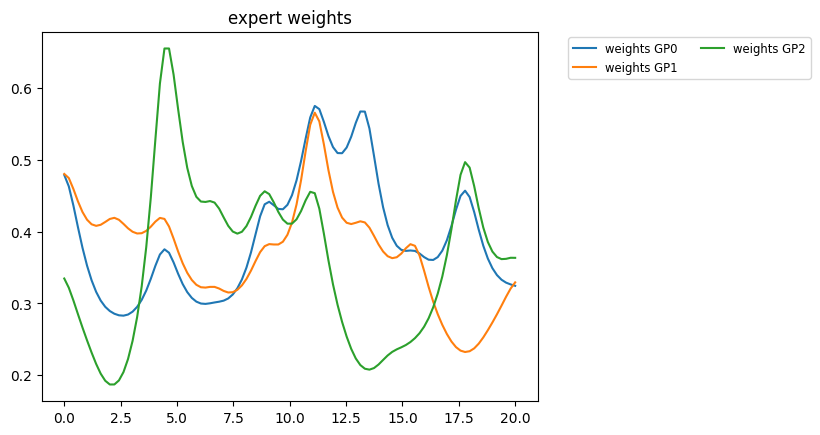

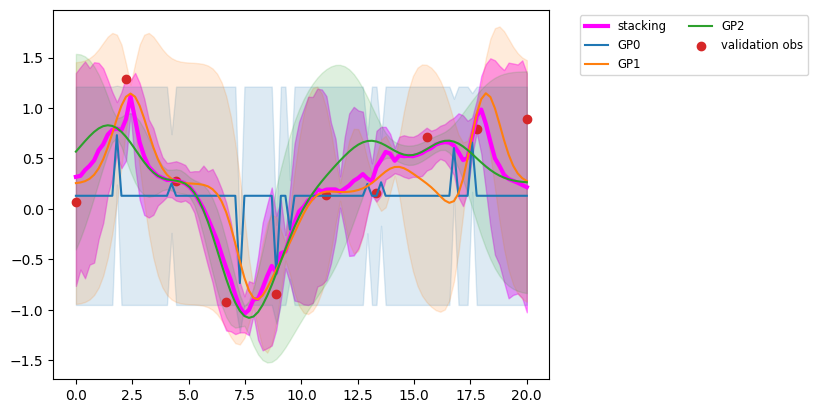

In [189]:
w = preds_phs["w"].mean(0)
plot_stacking(w,ysamples_phs)

In [190]:
print(lpd_phs_test.mean())

0.14353804189274225


## BHS

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
kernel_length[0]      1.22      0.65      1.05      0.50      2.14    350.88      1.00
kernel_length[1]      1.23      0.71      1.03      0.39      2.07    271.47      1.01
kernel_length[2]      1.27      0.81      1.04      0.43      2.11    174.52      1.01
 kernel_noise[0]      0.73      0.57      0.60      0.00      1.62    176.41      1.01
 kernel_noise[1]      0.81      0.57      0.67      0.00      1.63    238.71      1.01
 kernel_noise[2]      0.77      0.59      0.68      0.01      1.52    157.86      1.03
   kernel_var[0]      0.70      0.57      0.54      0.02      1.55    222.84      1.00
   kernel_var[1]      0.88      0.62      0.78      0.00      1.67    212.57      1.00
   kernel_var[2]      0.77      0.61      0.64      0.01      1.66    246.52      1.00
       w_un[0,0]     -1.10      1.20     -1.13     -3.11      0.84    399.82      1.00
       w_un[0,1]     -1.40      1.10     -

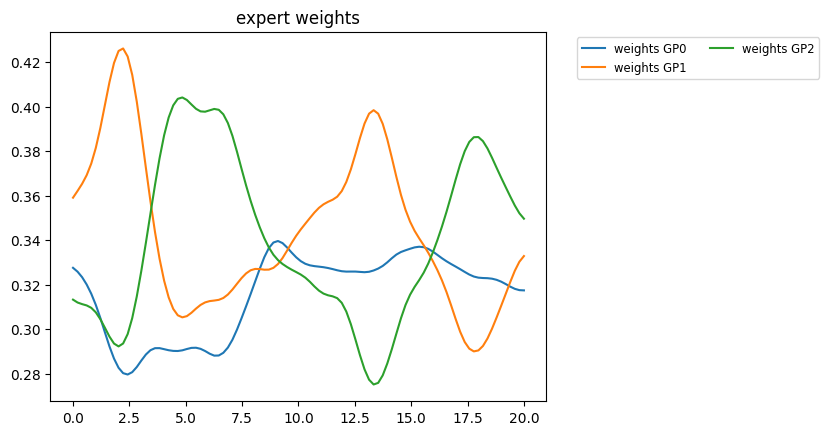

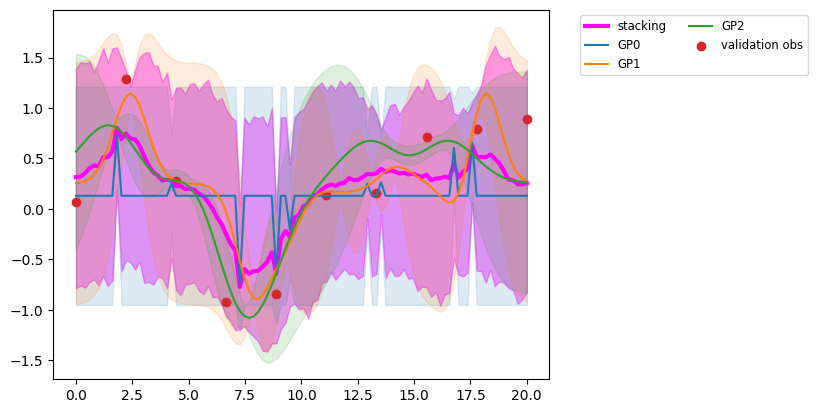

In [191]:
samples_bhs = train_stacking(model=bhs)
preds_bhs, lpd_bhs_test = predict_stacking(bhs,samples=samples_bhs)

ysamples_bhs = get_ysamples(mus=mu_preds_test,stds=std_preds_test,w=preds_bhs["w"].mean(0))
plot_stacking(preds_bhs["w"].mean(0).T,ysamples_bhs)

In [192]:
print(lpd_bhs_test.mean())

-0.1407510670972512


In [193]:
%%script true
# forma equivalente de calcular el lpd en bhs (da igual si hacemos la media de los pesos o la media de las lpd para cada set de pesos)
w_aqui = preds_bhs["w"].mean(0)

lpd_point = jax.scipy.stats.norm.logpdf(
                jnp.tile(y_test.reshape(-1,1),mu_preds_test.shape[1]), 
                loc=mu_preds_test, 
                scale=std_preds_test,
                )
lpd_point = jax.nn.logsumexp(lpd_point + jnp.log(w_aqui), axis=1)
lpd_point.mean()

## Plotting the predictive pdfs of PHS and BHS 

In [194]:
# X_test[itest]

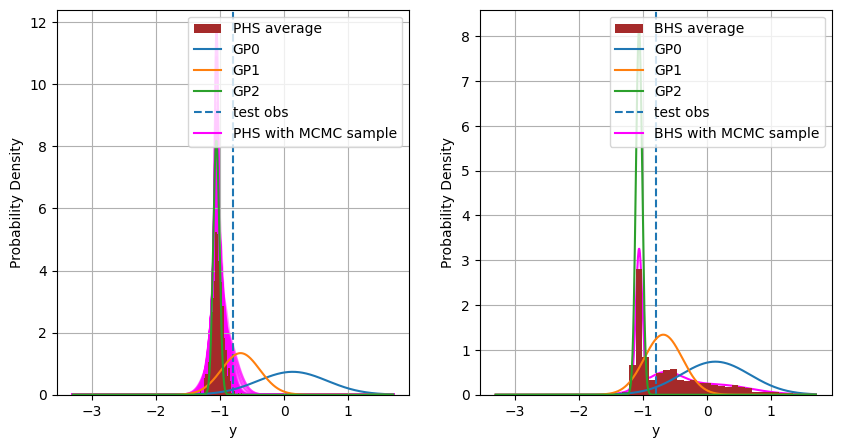

<Figure size 640x480 with 0 Axes>

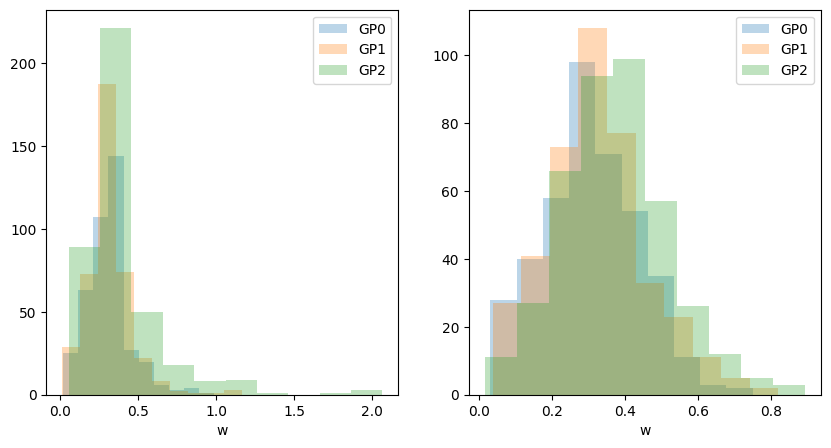

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mus=preds_phs["mean_fused"].T
stds=preds_phs["std_fused"].T

itest = 37

# Generate x values
x = np.linspace(y_test[itest]-2.5, y_test[itest]+2.5, 1000)

fig,ax = plt.subplots(figsize = (10,5), nrows=1,ncols=2)

# Plot each Gaussian PDF
for k,(mu, sigma) in enumerate(list(zip(mus[itest,:], stds[itest,:]))):
    pdf = norm.pdf(x, mu, sigma)
    ax[0].plot(x, pdf,color="magenta",alpha=0.4,zorder=1)
    # print(pdf.max())    

    # pdf = np.zeros(shape=(1000,))
    # for i in range(preds_bhs["w"].mean(0).shape[1]):
    #     pdf += preds_bhs["w"][k,itest,i]*norm.pdf(x, mu_preds_test[itest,i], std_preds_test[itest,i])
    #     ax[1].plot(x, pdf, color = "magenta",alpha = 0.4, zorder=1)

pdf = np.zeros(shape=(1000,))
for i in range(preds_bhs["w"].mean(0).shape[1]):
    pdf += preds_bhs["w"].mean(0)[itest,i]*norm.pdf(x, mu_preds_test[itest,i], std_preds_test[itest,i])
ax[1].plot(x, pdf, color = "magenta",alpha = 1)


ax[0].hist(ysamples_phs[itest,:], bins=30, density=True, alpha=1, color='brown', label='PHS average', zorder=2)
ax[1].hist(ysamples_bhs[itest,:], bins=30, density=True, alpha=1, color='brown', label='BHS average', zorder=2)



for i in range(mu_preds_test.shape[1]): # these are the experts
    pdf = norm.pdf(x, mu_preds_test[itest,i], std_preds_test[itest,i])
    ax[0].plot(x, pdf,label = f"GP{i}", zorder=3)
    ax[1].plot(x, pdf,label = f"GP{i}", zorder=3)



ax[0].axvline(x=y_test[itest],linestyle = '--' ,label = 'test obs')
ax[1].axvline(x=y_test[itest],linestyle =  '--',label = 'test obs')

ax[0].plot([], [], label='PHS with MCMC sample', color='magenta')
ax[1].plot([], [], label='BHS with MCMC sample', color='magenta')

ax[0].set_xlabel('y')
ax[1].set_xlabel('y')

ax[0].set_ylabel('Probability Density')
ax[1].set_ylabel('Probability Density')
# plt.title('Multiple Gaussian PDFs')
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)




# let's plot histogram of the weights of both fusion rules
plt.figure()

# preds_phs["w"].shape = (Nsamp, Nexp, Ntest)
# preds_bhs["w"].shape = (Nsamp, Ntest, Nexp)

fig,ax = plt.subplots(figsize = (10,5), nrows=1,ncols=2)

for k in range(mu_preds_test.shape[1]):
    ax[0].hist( preds_phs["w"][:,k,itest], label = f"GP{k}",alpha=0.3)
    ax[1].hist( preds_bhs["w"][:,itest,k], label = f"GP{k}",alpha=0.3)

ax[0].set_xlabel("w")
ax[1].set_xlabel("w")
ax[0].legend();
ax[1].legend();

In [183]:
preds_bhs["w"].shape

(400, 100, 10)

In [205]:
%%script true
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the parameters for the two Gaussian distributions
mu1, sigma1 = -2, 2
mu2, sigma2 = 2, 2

# Generate x values for plotting
x = np.linspace(-10, 10, 1000)

# Generate weights for the mixture, ranging from 1 to 0
weights = np.linspace(1, 0, 10)

# Plot the mixture PDFs
plt.figure(figsize=(10, 6))

for w1 in weights:
    w2 = 1 - w1
    pdf = w1 * norm.pdf(x, mu1, sigma1) + w2 * norm.pdf(x, mu2, sigma2)
    plt.plot(x, pdf, label=f'$w_1={w1:.1f}, w_2={w2:.1f}$')

# Add labels and title
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Mixture of Two Gaussian PDFs')
plt.legend(title='Weights', loc='upper left')
plt.grid(True)
plt.show()
